## Investigate trimming

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

import functions_py.fates_xarray_functions as fa

In [2]:
pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

### Load the fates runs
1. Trimming reduced by 10%
2. Default trimming
3. Trimming increased by 10%
4. No trimming

In [3]:
fates = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/default_trim.Eb8be65d66e-F3a2becda.2023-10-26/run/default_trim.Eb8be65d66e-F3a2becda.2023-10-26.1920s.nc'
fates = xr.open_dataset(fates, decode_times=False)

fates_notrim = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/notrim.Eb8be65d66e-F3a2becda.2023-10-26/run/notrim.Eb8be65d66e-F3a2becda.2023-10-26.1920s.nc'
fates_notrim = xr.open_dataset(fates_notrim, decode_times=False)

fates_lowtrim = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/lowtrim.Eb8be65d66e-F3a2becda.2023-10-26/run/lowtrim.Eb8be65d66e-F3a2becda.2023-10-26.1920s.nc'
fates_lowtrim = xr.open_dataset(fates_lowtrim, decode_times=False)

fates_hightrim = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/hightrim.Eb8be65d66e-F3a2becda.2023-10-26/run/hightrim.Eb8be65d66e-F3a2becda.2023-10-26.1920s.nc'
fates_hightrim = xr.open_dataset(fates_hightrim, decode_times=False)

time = fates.variables['time'] / 365.
cohort_size_bins = fates.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

### LAI 

In [4]:
lai_canopy = fa.scpf_to_scls_by_pft(fates.FATES_LAI_CANOPY_SZPF, fates) * fates.FATES_FRACTION.mean(dim='time')
lai_canopy = lai_canopy.sum(dim='fates_levscls').mean(dim='time')
lai_ustory = fa.scpf_to_scls_by_pft(fates.FATES_LAI_USTORY_SZPF, fates) * fates.FATES_FRACTION.mean(dim='time')
lai_ustory = lai_ustory.sum(dim='fates_levscls').mean(dim='time')
lai = lai_canopy+lai_ustory

lai_canopy_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_LAI_CANOPY_SZPF, fates_notrim) * fates_notrim.FATES_FRACTION.mean(dim='time')
lai_canopy_notrim = lai_canopy_notrim.sum(dim='fates_levscls').mean(dim='time')
lai_ustory_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_LAI_USTORY_SZPF, fates_notrim) * fates_notrim.FATES_FRACTION.mean(dim='time')
lai_ustory_notrim = lai_ustory_notrim.sum(dim='fates_levscls').mean(dim='time')
lai_notrim = lai_canopy_notrim + lai_ustory_notrim

lai_canopy_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_LAI_CANOPY_SZPF, fates_lowtrim) * fates_lowtrim.FATES_FRACTION.mean(dim='time')
lai_canopy_lowtrim = lai_canopy_lowtrim.sum(dim='fates_levscls').mean(dim='time')
lai_ustory_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_LAI_USTORY_SZPF, fates_lowtrim) * fates_lowtrim.FATES_FRACTION.mean(dim='time')
lai_ustory_lowtrim = lai_ustory_lowtrim.sum(dim='fates_levscls').mean(dim='time')
lai_lowtrim = lai_canopy_lowtrim + lai_ustory_lowtrim

lai_canopy_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_LAI_CANOPY_SZPF, fates_hightrim) * fates_hightrim.FATES_FRACTION.mean(dim='time')
lai_canopy_hightrim = lai_canopy_hightrim.sum(dim='fates_levscls').mean(dim='time')
lai_ustory_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_LAI_USTORY_SZPF, fates_hightrim) * fates_hightrim.FATES_FRACTION.mean(dim='time')
lai_ustory_hightrim = lai_ustory_hightrim.sum(dim='fates_levscls').mean(dim='time')
lai_hightrim = lai_canopy_hightrim + lai_ustory_hightrim

lais = [lai_notrim, lai_lowtrim, lai, lai_hightrim]

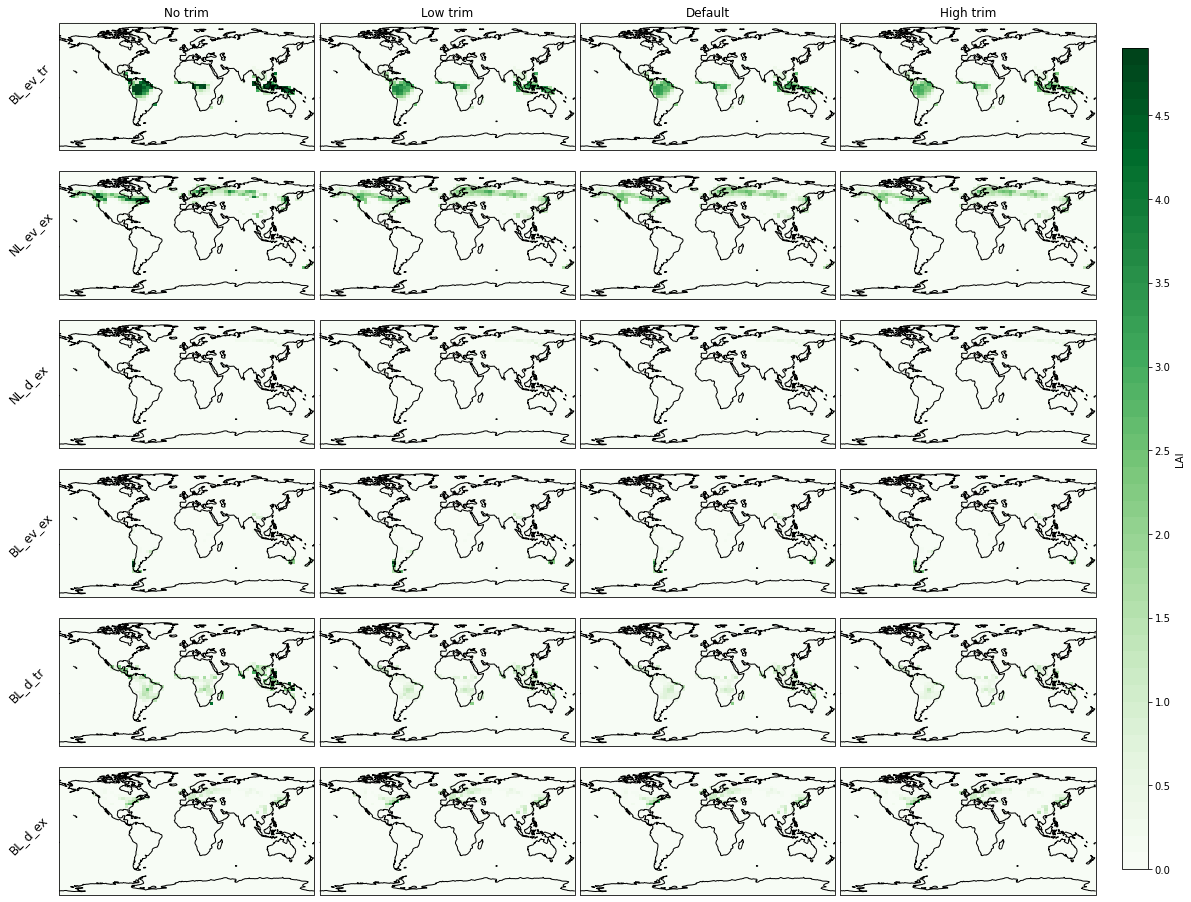

In [5]:
clevs=np.arange(0,5,0.1)
fig, axs = plt.subplots(nrows=6,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,19))
for j in range(0,4):
    tmp = lais[j]
    
    for i in range(0,6):
            cs= tmp.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
            ax=axs[i,j],add_colorbar=False)
            axs[i,j].coastlines()
            axs[i,j].set_title('')
            
axs[0,0].set_title('No trim', fontsize=12)
axs[0,1].set_title('Low trim', fontsize=12)
axs[0,2].set_title('Default', fontsize=12)
axs[0,3].set_title('High trim', fontsize=12)

fig.text(0.06, 0.85, 'BL_ev_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.74, 'NL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.63, 'NL_d_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.52, 'BL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.41, 'BL_d_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.3, 'BL_d_ex', va='center', rotation=45.0, fontsize=12)

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('LAI')

### Growth rates

##### Nplant

In [6]:
nplant_c = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_CANOPY_SZPF, fates) 
nplant_c = nplant_c * fates.FATES_FRACTION
nplant_c = nplant_c.sum(dim='fates_levscls')
nplant_u = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_USTORY_SZPF, fates) 
nplant_u = nplant_u * fates.FATES_FRACTION
nplant_u = nplant_u.sum(dim='fates_levscls')
nplant_c_notrim = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_CANOPY_SZPF, fates_notrim) 
nplant_c_notrim = nplant_c_notrim * fates_notrim.FATES_FRACTION
nplant_c_notrim = nplant_c_notrim.sum(dim='fates_levscls')
nplant_u_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_NPLANT_USTORY_SZPF, fates_notrim) 
nplant_u_notrim = nplant_u_notrim * fates_notrim.FATES_FRACTION
nplant_u_notrim = nplant_u_notrim.sum(dim='fates_levscls')
nplant_c_lowtrim = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_CANOPY_SZPF, fates_lowtrim) 
nplant_c_lowtrim = nplant_c_lowtrim * fates_lowtrim.FATES_FRACTION
nplant_c_lowtrim = nplant_c_lowtrim.sum(dim='fates_levscls')
nplant_u_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_NPLANT_USTORY_SZPF, fates_lowtrim) 
nplant_u_lowtrim = nplant_u_lowtrim * fates_lowtrim.FATES_FRACTION
nplant_u_lowtrim = nplant_u_lowtrim.sum(dim='fates_levscls')
nplant_c_hightrim = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_CANOPY_SZPF, fates_hightrim) 
nplant_c_hightrim = nplant_c_hightrim * fates_hightrim.FATES_FRACTION
nplant_c_hightrim = nplant_c_hightrim.sum(dim='fates_levscls')
nplant_u_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_NPLANT_USTORY_SZPF, fates_hightrim) 
nplant_u_hightrim = nplant_u_hightrim * fates_hightrim.FATES_FRACTION
nplant_u_hightrim = nplant_u_hightrim.sum(dim='fates_levscls')

##### Canopy growth

In [7]:
ddbh_canopy = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_CANOPY_SZPF, fates)
ddbh_canopy = ddbh_canopy * fates.FATES_FRACTION # multiply by fates fraction
ddbh_canopy = ddbh_canopy.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy  = ddbh_canopy / nplant_c # divide by nplant
ddbh_canopy = ddbh_canopy.mean(dim='time') # mean over time
ddbh_canopy = ddbh_canopy * 100 # convert to cm
ddbh_canopy_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_DDBH_CANOPY_SZPF, fates_notrim)
ddbh_canopy_notrim = ddbh_canopy_notrim * fates_notrim.FATES_FRACTION # multiply by fates fraction
ddbh_canopy_notrim = ddbh_canopy_notrim.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy_notrim  = ddbh_canopy_notrim / nplant_c_notrim # divide by nplant
ddbh_canopy_notrim = ddbh_canopy_notrim.mean(dim='time') # mean over time
ddbh_canopy_notrim = ddbh_canopy_notrim * 100 # convert to cm
ddbh_canopy_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_DDBH_CANOPY_SZPF, fates_lowtrim)
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim * fates_lowtrim.FATES_FRACTION # multiply by fates fraction
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy_lowtrim  = ddbh_canopy_lowtrim / nplant_c_lowtrim # divide by nplant
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim.mean(dim='time') # mean over time
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim * 100 # convert to cm
ddbh_canopy_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_DDBH_CANOPY_SZPF, fates_hightrim)
ddbh_canopy_hightrim = ddbh_canopy_hightrim * fates_hightrim.FATES_FRACTION # multiply by fates fraction
ddbh_canopy_hightrim = ddbh_canopy_hightrim.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy_hightrim  = ddbh_canopy_hightrim / nplant_c_hightrim # divide by nplant
ddbh_canopy_hightrim = ddbh_canopy_hightrim.mean(dim='time') # mean over time
ddbh_canopy_hightrim = ddbh_canopy_hightrim * 100 # convert to cm

##### Ustory growth

In [8]:
ddbh_ustory = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_USTORY_SZPF, fates)
ddbh_ustory = ddbh_ustory * fates.FATES_FRACTION # multiply by fates fraction
ddbh_ustory = ddbh_ustory.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory  = ddbh_ustory / nplant_u # divide by nplant
ddbh_ustory = ddbh_ustory.mean(dim='time') # mean over time
ddbh_ustory = ddbh_ustory * 100 # convert to cm
ddbh_ustory_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_DDBH_USTORY_SZPF, fates_notrim)
ddbh_ustory_notrim = ddbh_ustory_notrim * fates_notrim.FATES_FRACTION # multiply by fates fraction
ddbh_ustory_notrim = ddbh_ustory_notrim.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory_notrim  = ddbh_ustory_notrim / nplant_u_notrim # divide by nplant
ddbh_ustory_notrim = ddbh_ustory_notrim.mean(dim='time') # mean over time
ddbh_ustory_notrim = ddbh_ustory_notrim * 100 # convert to cm
ddbh_ustory_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_DDBH_USTORY_SZPF, fates_lowtrim)
ddbh_ustory_lowtrim = ddbh_ustory_lowtrim * fates_lowtrim.FATES_FRACTION # multiply by fates fraction
ddbh_ustory_lowtrim = ddbh_ustory_lowtrim.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory_lowtrim  = ddbh_ustory_lowtrim / nplant_u_lowtrim # divide by nplant
ddbh_ustory_lowtrim = ddbh_ustory_lowtrim.mean(dim='time') # mean over time
ddbh_ustory_lowtrim = ddbh_ustory_lowtrim * 100 # convert to cm
ddbh_ustory_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_DDBH_USTORY_SZPF, fates_hightrim)
ddbh_ustory_hightrim = ddbh_ustory_hightrim * fates_hightrim.FATES_FRACTION # multiply by fates fraction
ddbh_ustory_hightrim = ddbh_ustory_hightrim.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory_hightrim  = ddbh_ustory_hightrim / nplant_u_hightrim # divide by nplant
ddbh_ustory_hightrim = ddbh_ustory_hightrim.mean(dim='time') # mean over time
ddbh_ustory_hightrim = ddbh_ustory_hightrim * 100 # convert to cm

In [9]:
ddbh_ustory_list = [ddbh_ustory_notrim, ddbh_ustory_lowtrim, ddbh_ustory, ddbh_ustory_hightrim]

In [10]:
ddbh_canopy_list = [ddbh_canopy_notrim, ddbh_canopy_lowtrim, ddbh_canopy, ddbh_canopy_hightrim]

### Canopy growth rates

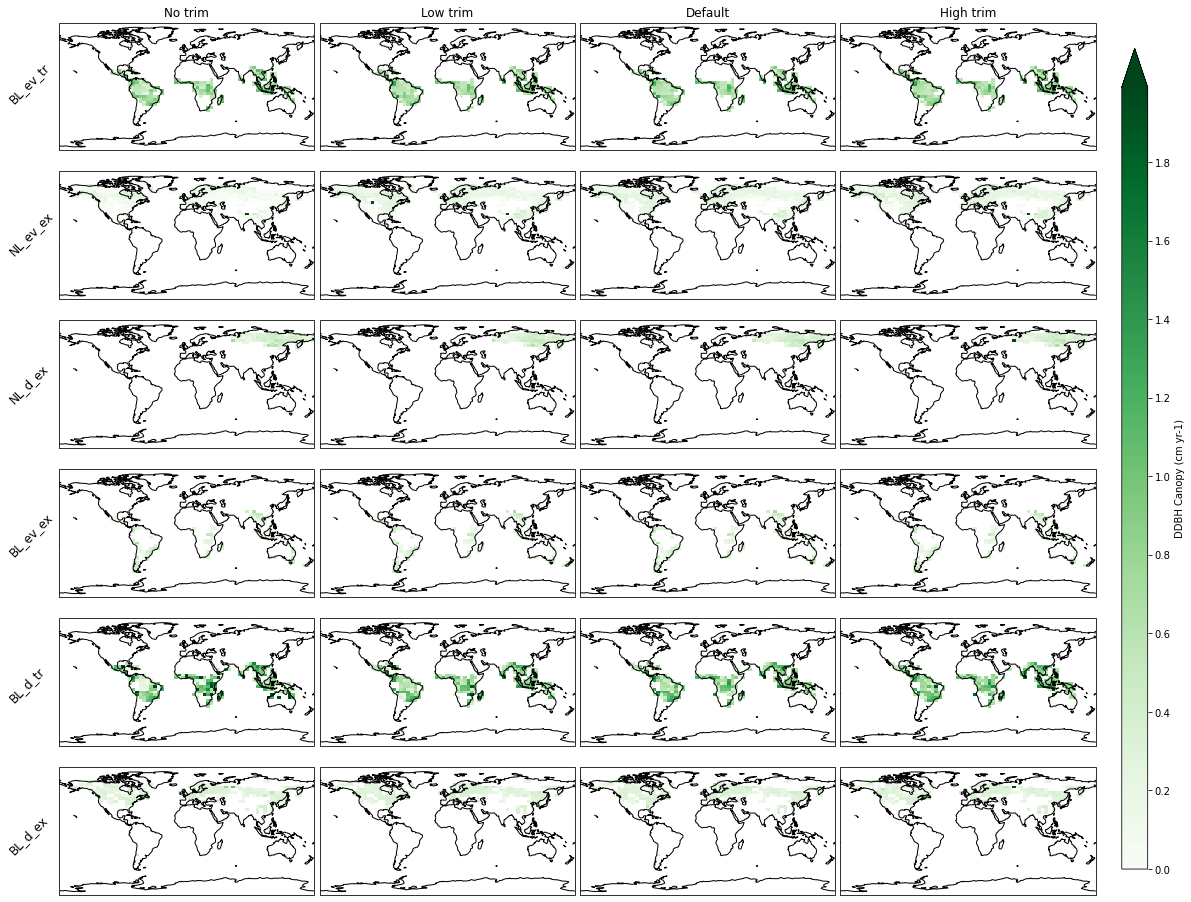

In [11]:
clevs=np.arange(0,2,0.01)
fig, axs = plt.subplots(nrows=6,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,19))
for j in range(0,4):
    tmp = ddbh_canopy_list[j]
    
    for i in range(0,6):
            cs= tmp.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
            ax=axs[i,j],add_colorbar=False)
            axs[i,j].coastlines()
            axs[i,j].set_title('')
            
axs[0,0].set_title('No trim', fontsize=12)
axs[0,1].set_title('Low trim', fontsize=12)
axs[0,2].set_title('Default', fontsize=12)
axs[0,3].set_title('High trim', fontsize=12)

fig.text(0.06, 0.85, 'BL_ev_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.74, 'NL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.63, 'NL_d_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.52, 'BL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.41, 'BL_d_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.3, 'BL_d_ex', va='center', rotation=45.0, fontsize=12)

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('DDBH Canopy (cm yr-1)')

### Understory growth rates

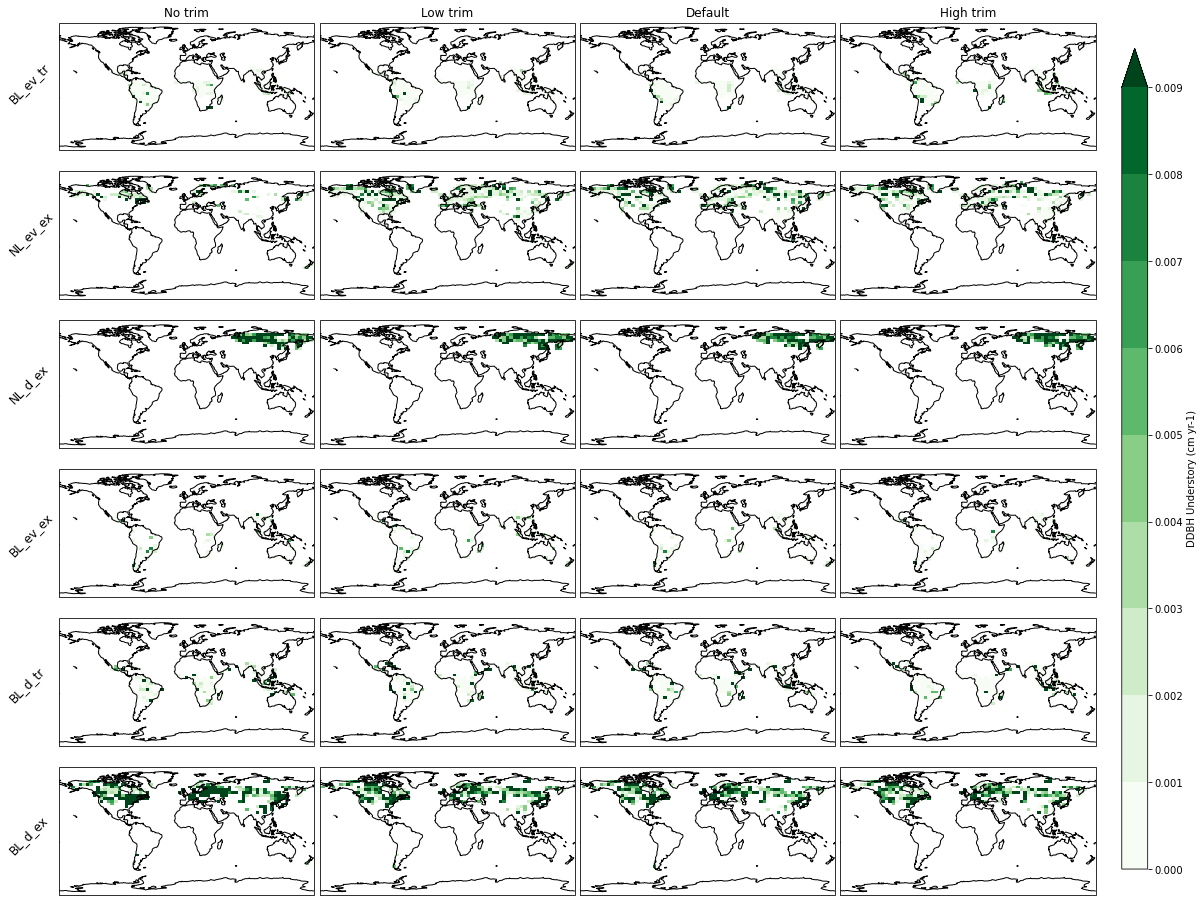

In [12]:
clevs=np.arange(0,0.01,0.001)
fig, axs = plt.subplots(nrows=6,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,19))
for j in range(0,4):
    tmp = ddbh_ustory_list[j]
    
    for i in range(0,6):
            cs= tmp.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens',
            ax=axs[i,j],add_colorbar=False)
            axs[i,j].coastlines()
            axs[i,j].set_title('')
            
axs[0,0].set_title('No trim', fontsize=12)
axs[0,1].set_title('Low trim', fontsize=12)
axs[0,2].set_title('Default', fontsize=12)
axs[0,3].set_title('High trim', fontsize=12)

fig.text(0.06, 0.85, 'BL_ev_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.74, 'NL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.63, 'NL_d_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.52, 'BL_ev_ex', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.41, 'BL_d_tr', va='center', rotation=45.0, fontsize=12)
fig.text(0.06, 0.3, 'BL_d_ex', va='center', rotation=45.0, fontsize=12)

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('DDBH Understory (cm yr-1)')

### Average for each PFT

In [13]:
ddbh_canopy = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_CANOPY_SZPF, fates)
ddbh_canopy = ddbh_canopy * fates.FATES_FRACTION # multiply by fates fraction
ddbh_canopy = ddbh_canopy.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy  = ddbh_canopy / nplant_c # divide by nplant
ddbh_canopy = ddbh_canopy.mean(dim=['lat','lon']) # mean over space
ddbh_canopy = ddbh_canopy * 100 # convert to cm

ddbh_canopy_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_DDBH_CANOPY_SZPF, fates_notrim)
ddbh_canopy_notrim = ddbh_canopy_notrim * fates_notrim.FATES_FRACTION # multiply by fates fraction
ddbh_canopy_notrim = ddbh_canopy_notrim.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy_notrim  = ddbh_canopy_notrim / nplant_c_notrim # divide by nplant
ddbh_canopy_notrim = ddbh_canopy_notrim.mean(dim=['lat','lon']) # mean over time
ddbh_canopy_notrim = ddbh_canopy_notrim * 100 # convert to cm

ddbh_canopy_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_DDBH_CANOPY_SZPF, fates_lowtrim)
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim * fates_lowtrim.FATES_FRACTION # multiply by fates fraction
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy_lowtrim  = ddbh_canopy_lowtrim / nplant_c_lowtrim # divide by nplant
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim.mean(dim=['lat','lon']) # mean over time
ddbh_canopy_lowtrim = ddbh_canopy_lowtrim * 100 # convert to cm

ddbh_canopy_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_DDBH_CANOPY_SZPF, fates_hightrim)
ddbh_canopy_hightrim = ddbh_canopy_hightrim * fates_hightrim.FATES_FRACTION # multiply by fates fraction
ddbh_canopy_hightrim = ddbh_canopy_hightrim.sum(dim='fates_levscls') # sum over sizes
ddbh_canopy_hightrim  = ddbh_canopy_hightrim / nplant_c_hightrim # divide by nplant
ddbh_canopy_hightrim = ddbh_canopy_hightrim.mean(dim=['lat','lon']) # mean over time
ddbh_canopy_hightrim = ddbh_canopy_hightrim * 100 # convert to cm


###  Canopy growth rates (spatially averaged)

''

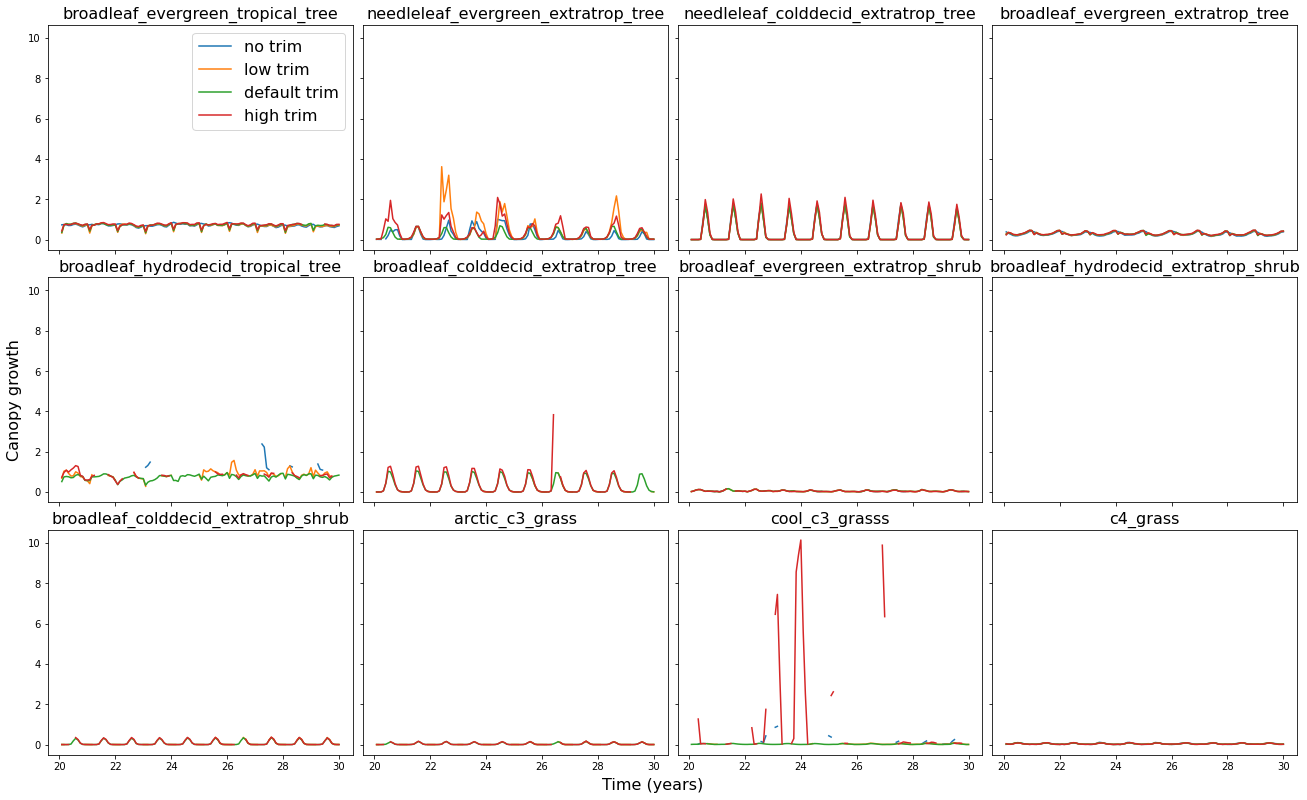

In [14]:
fig, axs = plt.subplots(nrows=3,ncols=4,
                        figsize=(18,11), constrained_layout=True, sharex=True, sharey=True)
axs = axs.flatten()

for  i in range(0,12) :
    axs[i].plot(time, ddbh_canopy_notrim.isel(fates_levpft=i), label = 'no trim')
    axs[i].plot(time, ddbh_canopy_lowtrim.isel(fates_levpft=i), label = 'low trim')
    axs[i].plot(time, ddbh_canopy.isel(fates_levpft=i), label = 'default trim')
    axs[i].plot(time, ddbh_canopy_hightrim.isel(fates_levpft=i), label = 'high trim')
    axs[i].set_title(pftnames[i], fontsize=16)

    
axs[0].legend(fontsize=16)

fig.supylabel('Canopy growth', fontsize=16)
fig.supxlabel('Time (years)', fontsize=16)
;

In [15]:
ddbh_ustory = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_USTORY_SZPF, fates)
ddbh_ustory = ddbh_ustory * fates.FATES_FRACTION # multiply by fates fraction
ddbh_ustory = ddbh_ustory.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory  = ddbh_ustory / nplant_u # divide by nplant
ddbh_ustory = ddbh_ustory.mean(dim=['lat','lon']) # mean over space
ddbh_ustory = ddbh_ustory * 100 # convert to cm

ddbh_ustory_notrim = fa.scpf_to_scls_by_pft(fates_notrim.FATES_DDBH_USTORY_SZPF, fates_notrim)
ddbh_ustory_notrim = ddbh_ustory_notrim * fates_notrim.FATES_FRACTION # multiply by fates fraction
ddbh_ustory_notrim = ddbh_ustory_notrim.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory_notrim  = ddbh_ustory_notrim / nplant_u_notrim # divide by nplant
ddbh_ustory_notrim = ddbh_ustory_notrim.mean(dim=['lat','lon']) # mean over time
ddbh_ustory_notrim = ddbh_ustory_notrim * 100 # convert to cm

ddbh_ustory_lowtrim = fa.scpf_to_scls_by_pft(fates_lowtrim.FATES_DDBH_USTORY_SZPF, fates_lowtrim)
ddbh_ustory_lowtrim = ddbh_ustory_lowtrim * fates_lowtrim.FATES_FRACTION # multiply by fates fraction
ddbh_ustory_lowtrim = ddbh_ustory_lowtrim.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory_lowtrim  = ddbh_ustory_lowtrim / nplant_u_lowtrim # divide by nplant
ddbh_ustory_lowtrim = ddbh_ustory_lowtrim.mean(dim=['lat','lon']) # mean over time
ddbh_ustory_lowtrim = ddbh_ustory_lowtrim * 100 # convert to cm

ddbh_ustory_hightrim = fa.scpf_to_scls_by_pft(fates_hightrim.FATES_DDBH_USTORY_SZPF, fates_hightrim)
ddbh_ustory_hightrim = ddbh_ustory_hightrim * fates_hightrim.FATES_FRACTION # multiply by fates fraction
ddbh_ustory_hightrim = ddbh_ustory_hightrim.sum(dim='fates_levscls') # sum over sizes
ddbh_ustory_hightrim  = ddbh_ustory_hightrim / nplant_u_hightrim # divide by nplant
ddbh_ustory_hightrim = ddbh_ustory_hightrim.mean(dim=['lat','lon']) # mean over time
ddbh_ustory_hightrim = ddbh_ustory_hightrim * 100 # convert to cm


### Understory growth rates (spatially averaged)

''

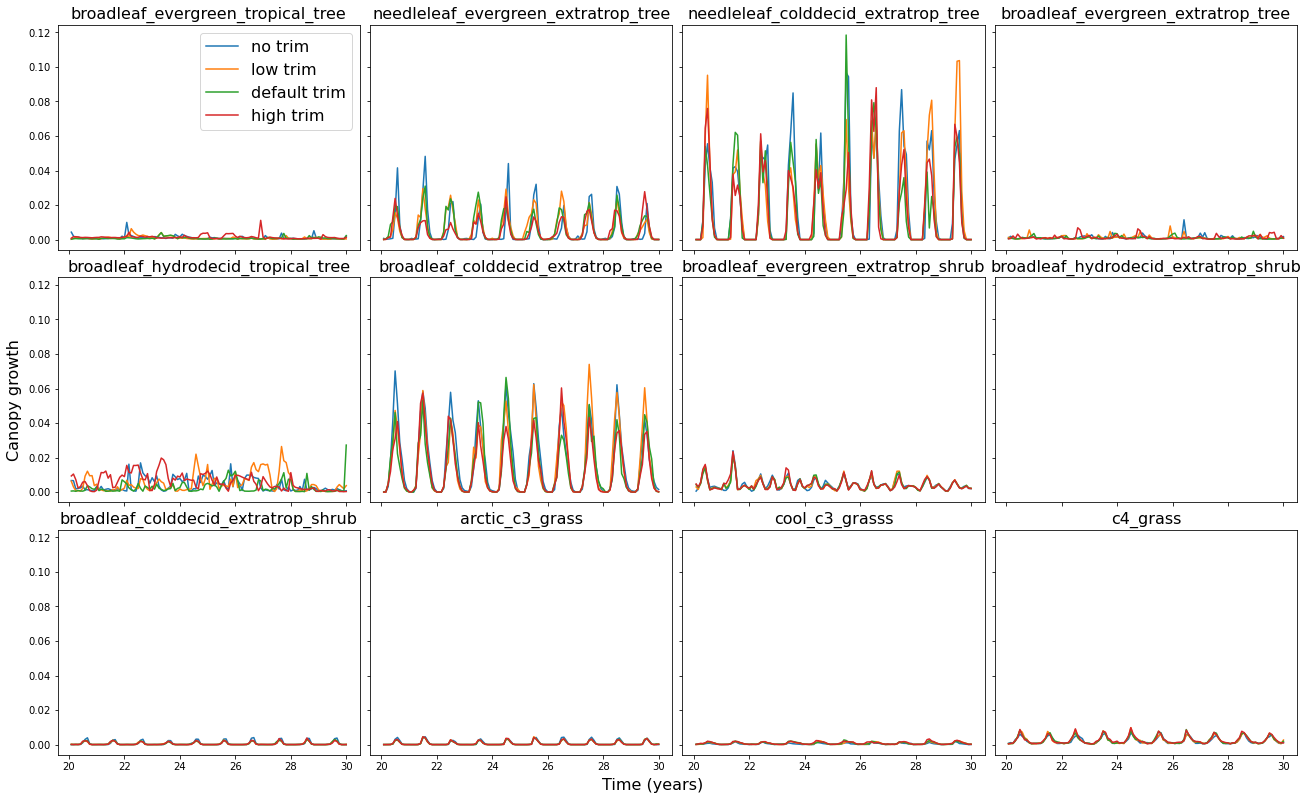

In [16]:
fig, axs = plt.subplots(nrows=3,ncols=4,
                        figsize=(18,11), constrained_layout=True, sharex=True, sharey=True)
axs = axs.flatten()

for  i in range(0,12) :
    axs[i].plot(time, ddbh_ustory_notrim.isel(fates_levpft=i), label = 'no trim')
    axs[i].plot(time, ddbh_ustory_lowtrim.isel(fates_levpft=i), label = 'low trim')
    axs[i].plot(time, ddbh_ustory.isel(fates_levpft=i), label = 'default trim')
    axs[i].plot(time, ddbh_ustory_hightrim.isel(fates_levpft=i), label = 'high trim')
    axs[i].set_title(pftnames[i], fontsize=16)

    
axs[0].legend(fontsize=16)

fig.supylabel('Canopy growth', fontsize=16)
fig.supxlabel('Time (years)', fontsize=16)
;